# Drug Consumption

## Data Understanding
### Import von benötigten Bibliotheken

In [293]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Datensatz abrufen

In [294]:
dataset = fetch_ucirepo(id=373)

### Daten (Features und Zielvariable)

In [295]:
X = dataset.data.features.drop(columns=['age', 'gender', 'ethnicity', 'country'], errors='ignore')
y = dataset.data.targets

### Erste Übersicht der Features und der Zielvariablen

In [296]:
print("Übersicht der Merkmale:")
print(X.head())

print("")
print("Übersicht der Targets in den Zielklassen:")
print(y.head())

print("")
print("Übersicht über Datentypen im Datensatz")
print(X.dtypes)
print(y.dtypes)

Übersicht der Merkmale:
   education   nscore   escore   oscore   ascore   cscore  impuslive       ss
0   -0.05921  0.31287 -0.57545 -0.58331 -0.91699 -0.00665   -0.21712 -1.18084
1    1.98437 -0.67825  1.93886  1.43533  0.76096 -0.14277   -0.71126 -0.21575
2   -0.05921 -0.46725  0.80523 -0.84732 -1.62090 -1.01450   -1.37983  0.40148
3    1.16365 -0.14882 -0.80615 -0.01928  0.59042  0.58489   -1.37983 -1.18084
4    1.98437  0.73545 -1.63340 -0.45174 -0.30172  1.30612   -0.21712 -0.21575

Übersicht der Targets in den Zielklassen:
  alcohol amphet amyl benzos caff cannabis choc coke crack ecstasy heroin  \
0     CL5    CL2  CL0    CL2  CL6      CL0  CL5  CL0   CL0     CL0    CL0   
1     CL5    CL2  CL2    CL0  CL6      CL4  CL6  CL3   CL0     CL4    CL0   
2     CL6    CL0  CL0    CL0  CL6      CL3  CL4  CL0   CL0     CL0    CL0   
3     CL4    CL0  CL0    CL3  CL5      CL2  CL4  CL2   CL0     CL0    CL0   
4     CL4    CL1  CL1    CL0  CL6      CL3  CL6  CL0   CL0     CL1    CL0   

  

### Lage- und Streuungsmaße

Lage- und Streuungsmaße der Features:
         education       nscore       escore       oscore       ascore  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     -0.003806     0.000047    -0.000163    -0.000534    -0.000245   
std       0.950078     0.998106     0.997448     0.996229     0.997440   
min      -2.435910    -3.464360    -3.273930    -3.273930    -3.464360   
25%      -0.611130    -0.678250    -0.695090    -0.717270    -0.606330   
50%      -0.059210     0.042570     0.003320    -0.019280    -0.017290   
75%       0.454680     0.629670     0.637790     0.723300     0.760960   
max       1.984370     3.273930     3.273930     2.901610     3.464360   

            cscore    impuslive           ss  
count  1885.000000  1885.000000  1885.000000  
mean     -0.000386     0.007216    -0.003292  
std       0.997523     0.954435     0.963701  
min      -3.464360    -2.555240    -2.078480  
25%      -0.652530    -0.711260    -0.525930  
50%      -0.0

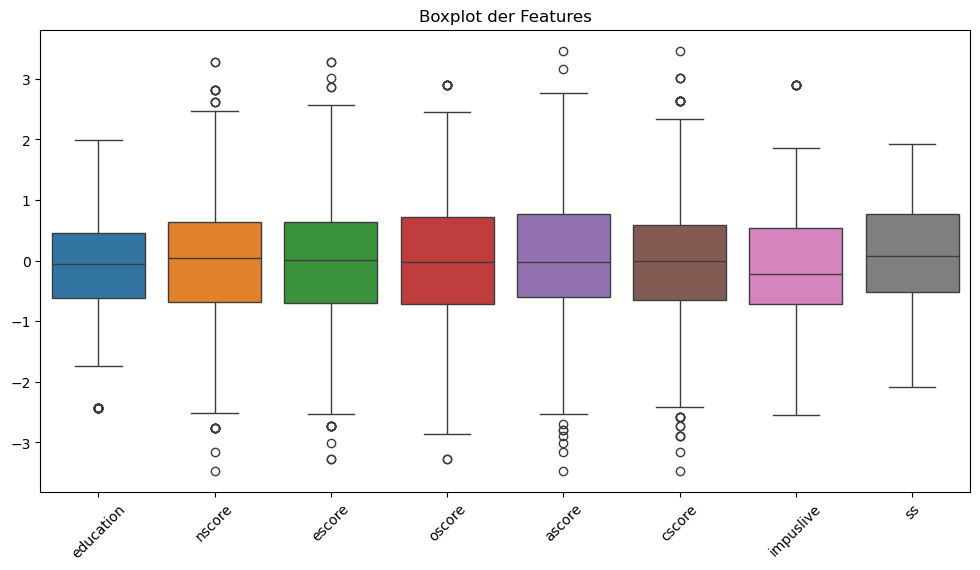

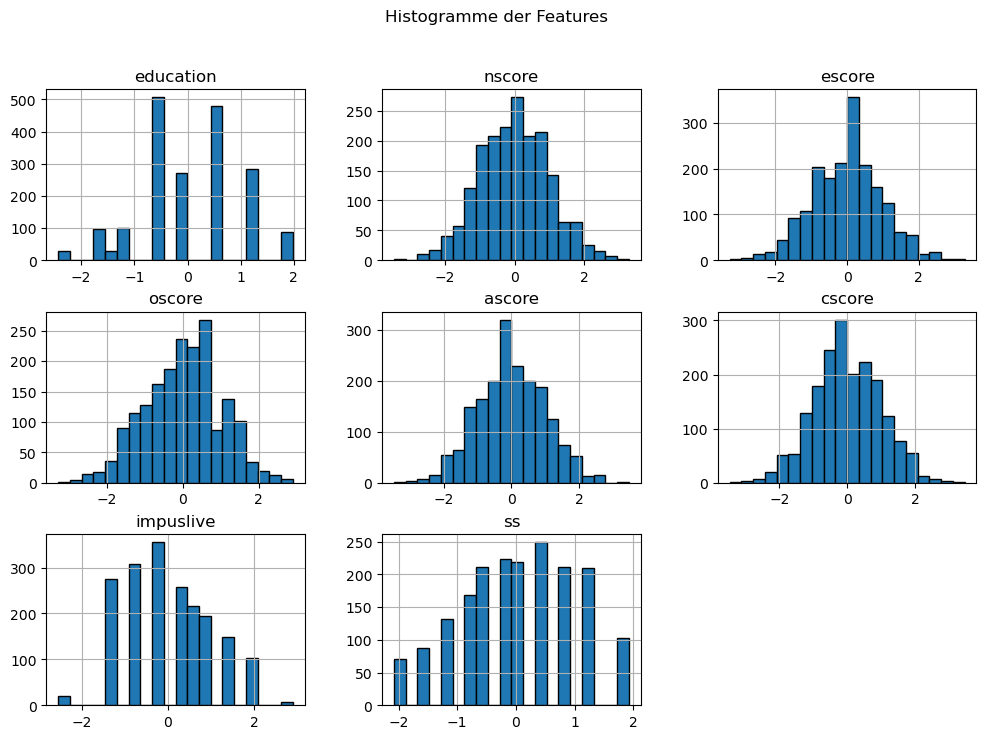

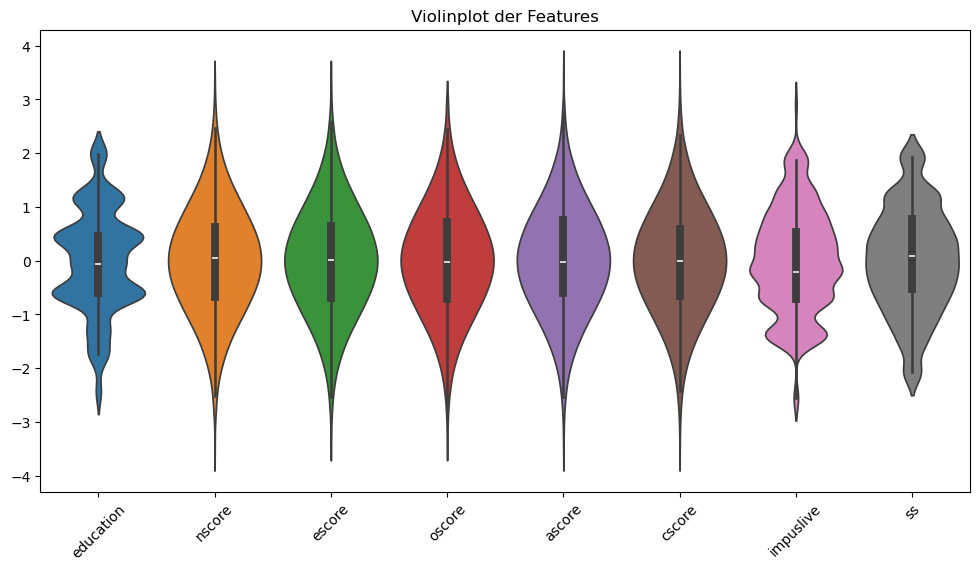

In [297]:
print("Lage- und Streuungsmaße der Features:")
print(X.describe())

plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title("Boxplot der Features")
plt.show()

X.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histogramme der Features")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=X)
plt.xticks(rotation=45)
plt.title("Violinplot der Features")
plt.show()


### Enthaltene Drogen im Datensatz

In [298]:
drug_columns = ['cannabis', 'coke', 'ecstasy', 'heroin', 'meth', 'mushrooms', 'nicotine', 'lsd', 'amphet', 'crack', 'alcohol']

### Primäre Auswahl an zu analysierenden Drogen

In [299]:
chosen_drugs = ['cannabis', 'coke', 'nicotine'] 

### Visualisierung der Verteilung des Konsums für jede Droge

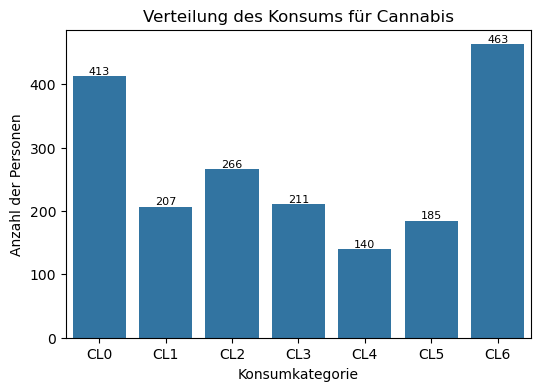

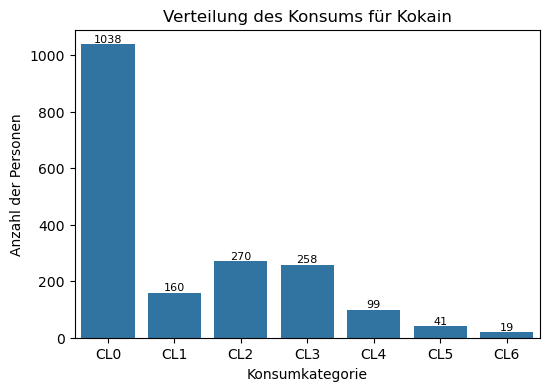

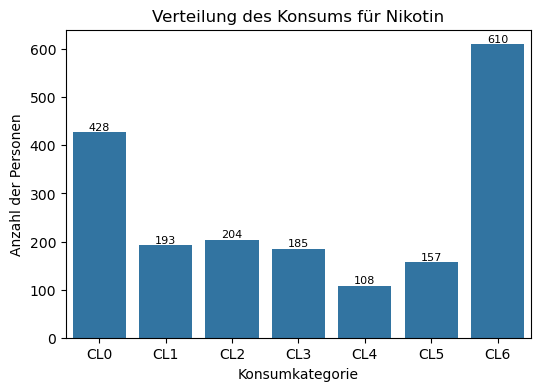

In [300]:
drug_names = {
    'cannabis': 'Cannabis',
    'coke': 'Kokain',
    'nicotine': 'Nikotin',
}

for drug in chosen_drugs:
    plt.figure(figsize=(6, 4))
    
    value_counts = y[drug].value_counts().sort_values(ascending=False)
    
    ordered_categories = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    
    ax = sns.countplot(x=y[drug], order=ordered_categories)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height,  
                f'{int(height)}', ha="center", va="bottom", fontsize=8)
    
    plt.title(f"Verteilung des Konsums für {drug_names.get(drug, drug).capitalize()}")
    plt.xlabel('Konsumkategorie')
    plt.ylabel('Anzahl der Personen')
    plt.show()


### Funktion, die Modelle erstellt und evaluiert

--> Zielvariable für die gewählte Droge

In [301]:
drug_name = "cannabis"
y_selected = y[drug_name]

### Train-Test-Split

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y_selected, test_size=0.2, random_state=42)

### Verifizieren des Splits

In [303]:
print("\nTrainingsdaten (Features) : ", X_train.shape)
print("Testdaten (Features) : ", X_test.shape)



Trainingsdaten (Features) :  (1508, 8)
Testdaten (Features) :  (377, 8)


## Erstellen und Trainieren verschiedener Modelle
### Random Forest Modell

In [304]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

rf_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


### Logistische Regression Modell


In [305]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

logreg_model = LogisticRegression(max_iter=50, class_weight=class_weight_dict, random_state=42)

logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

### SVM Modell

In [306]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

svm_model = SVC(kernel='linear', class_weight=class_weight_dict, random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)


### Ergebnisse für alle Modelle

In [307]:
models = ['Random Forest', 'Logistische Regression', "SVM"]
accuracies = [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_logreg),
        accuracy_score(y_test, y_pred_svm)
    ]
classification_reports = [
        classification_report(y_test, y_pred_rf, zero_division=0),
        classification_report(y_test, y_pred_logreg, zero_division=0),
        classification_report(y_test, y_pred_svm, zero_division=0)
    ]
f1_scores = [
    f1_score(y_test, y_pred_rf, average='macro'),
    f1_score(y_test, y_pred_logreg, average='macro'),
    f1_score(y_test, y_pred_svm, average='macro')
]

### Ausgabe der Genauigkeit und Klassifikationsberichte

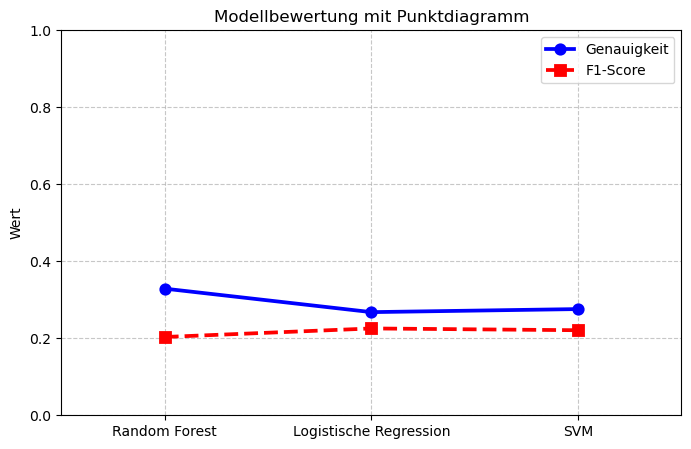

In [308]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=models, y=accuracies, color="blue", label="Genauigkeit", marker="o", linestyle="-")
sns.pointplot(x=models, y=f1_scores, color="red", label="F1-Score", marker="s", linestyle="--")

plt.ylabel("Wert")
plt.ylim(0, 1)
plt.title("Modellbewertung mit Punktdiagramm")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [309]:
for i in range(len(models)):
    print(f"\n{models[i]} - Genauigkeit: {accuracies[i]:.3f}")
    print(f"\n{models[i]} - F1-Score: {f1_scores[i]:.3f}") 
    print(f"\n{models[i]} - Klassifikationsbericht:")
    print(classification_reports[i])


Random Forest - Genauigkeit: 0.329

Random Forest - F1-Score: 0.203

Random Forest - Klassifikationsbericht:
              precision    recall  f1-score   support

         CL0       0.43      0.63      0.51        86
         CL1       0.21      0.21      0.21        28
         CL2       0.03      0.02      0.02        55
         CL3       0.21      0.05      0.08        57
         CL4       0.00      0.00      0.00        27
         CL5       0.23      0.09      0.13        32
         CL6       0.37      0.62      0.46        92

    accuracy                           0.33       377
   macro avg       0.21      0.23      0.20       377
weighted avg       0.26      0.33      0.27       377


Logistische Regression - Genauigkeit: 0.268

Logistische Regression - F1-Score: 0.226

Logistische Regression - Klassifikationsbericht:
              precision    recall  f1-score   support

         CL0       0.50      0.49      0.49        86
         CL1       0.11      0.21      0.15    

### Vergleich der Genauigkeiten

### Merkmalsgewichtung für trainierte Modelle

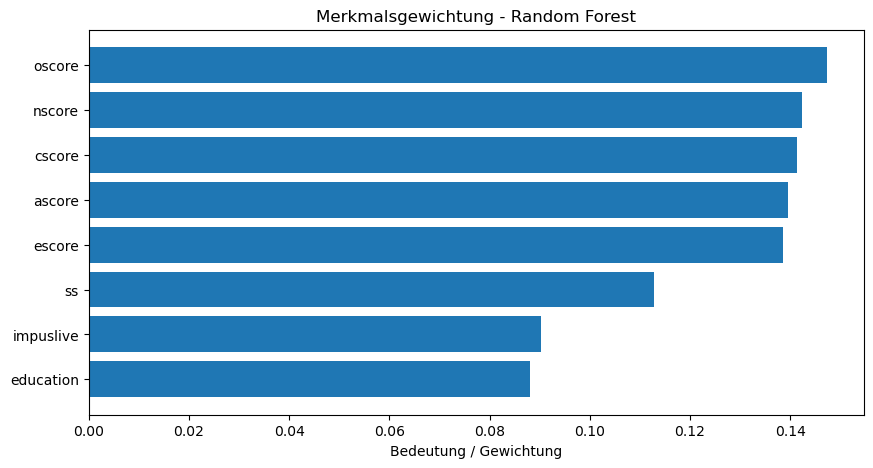

In [318]:
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist() if hasattr(X_train, "columns") else [f"Merkmal {i}" for i in range(num_features)]

def zeige_feature_importance(modellname, gewichtungen):
    gewichtungen = np.array(gewichtungen)

    if len(gewichtungen) != len(feature_names):  
        return  

    sortierte_indices = np.argsort(gewichtungen)
    plt.figure(figsize=(10, 5))
    plt.title(f"Merkmalsgewichtung - {modellname}")
    plt.barh(range(len(gewichtungen)), gewichtungen[sortierte_indices], align="center")
    plt.yticks(range(len(gewichtungen)), np.array(feature_names)[sortierte_indices])
    plt.xlabel("Bedeutung / Gewichtung")
    plt.show()

if hasattr(logreg_model, "coef_") and logreg_model.coef_.size > 0:
    zeige_feature_importance("Logistische Regression", np.ravel(logreg_model.coef_))

if hasattr(svm_model, "coef_"):
    zeige_feature_importance("SVM (Linear)", np.ravel(svm_model.coef_))

if hasattr(rf_model, "feature_importances_"):
    zeige_feature_importance("Random Forest", rf_model.feature_importances_)

### Konfusionsmatrix für jedes Modell

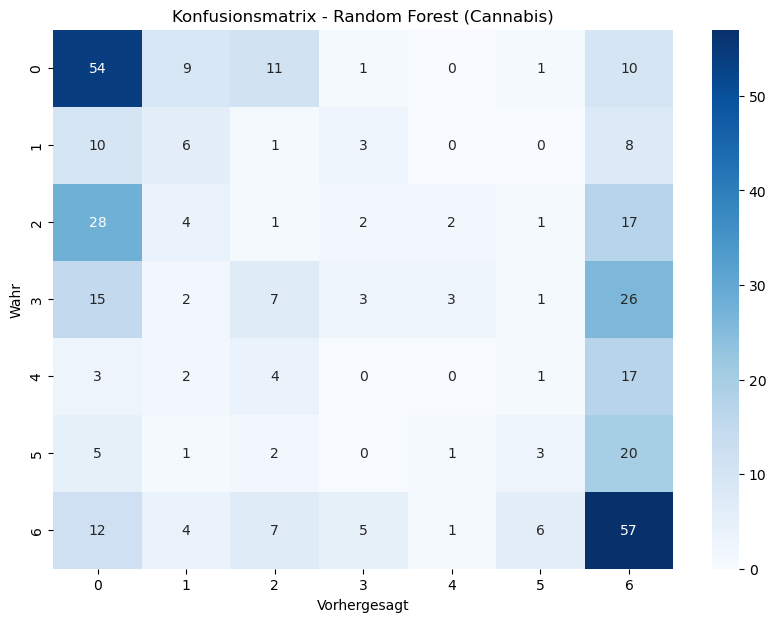

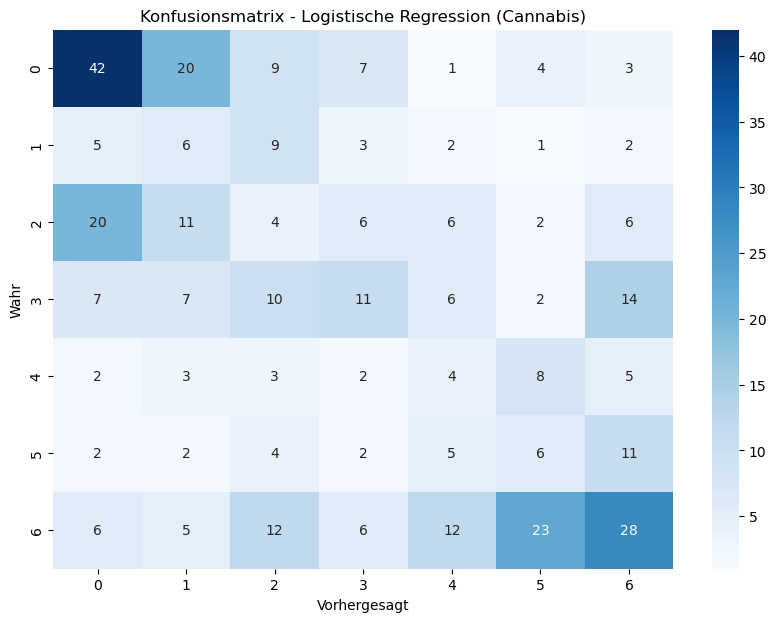

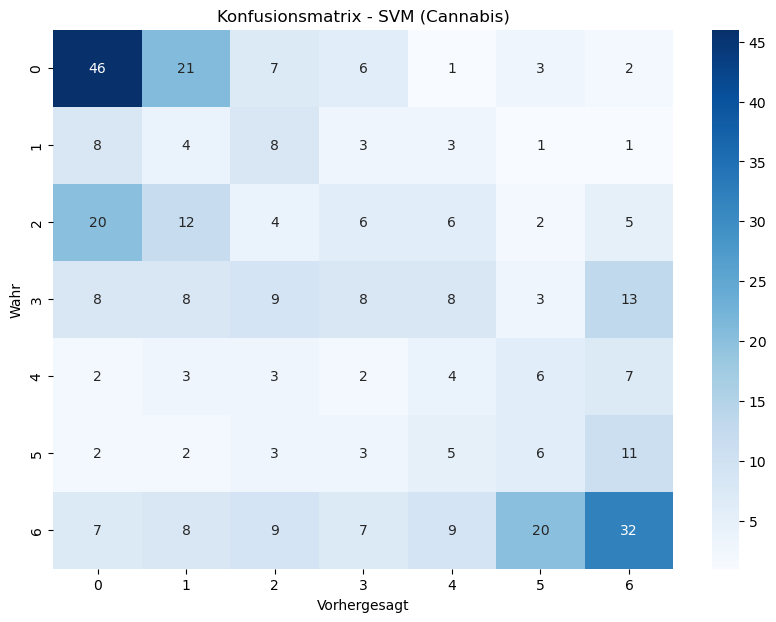

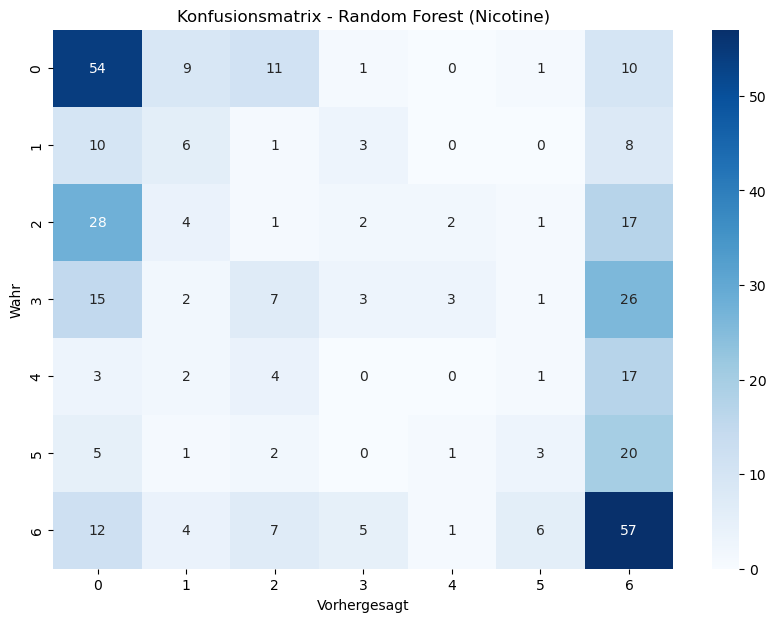

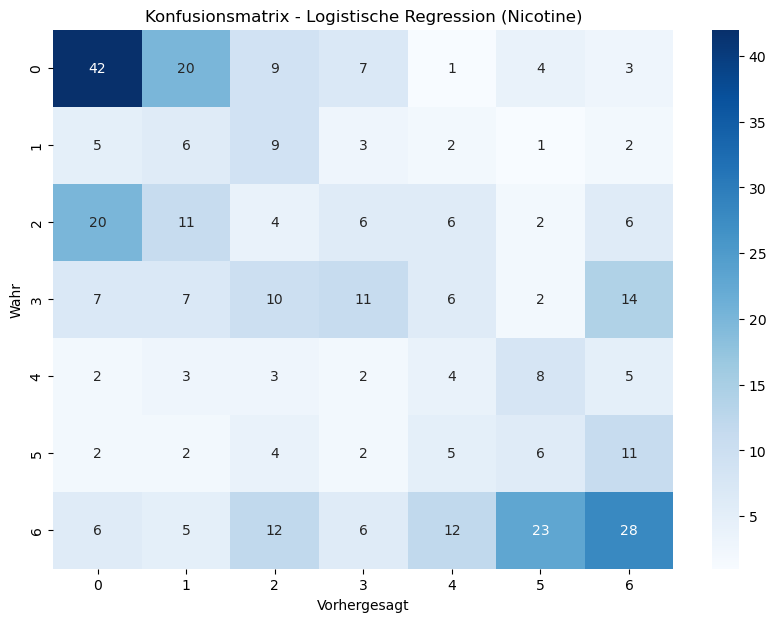

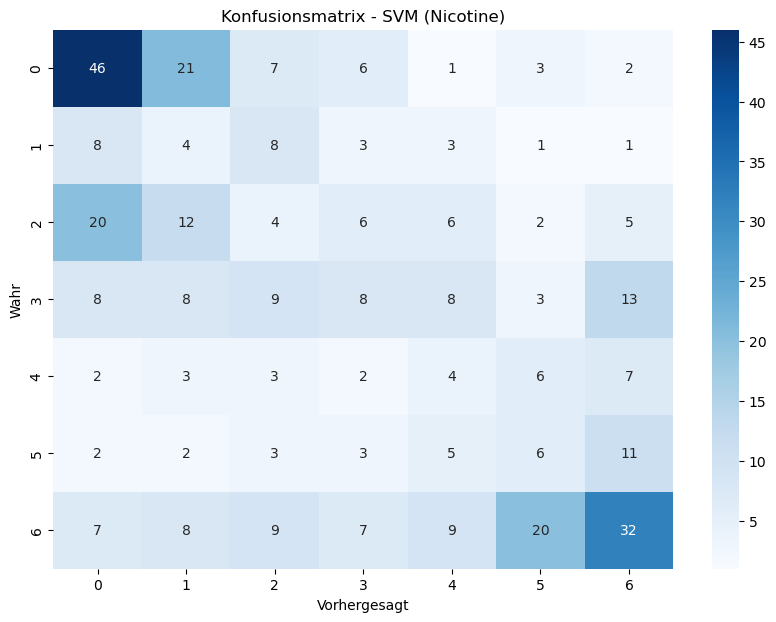

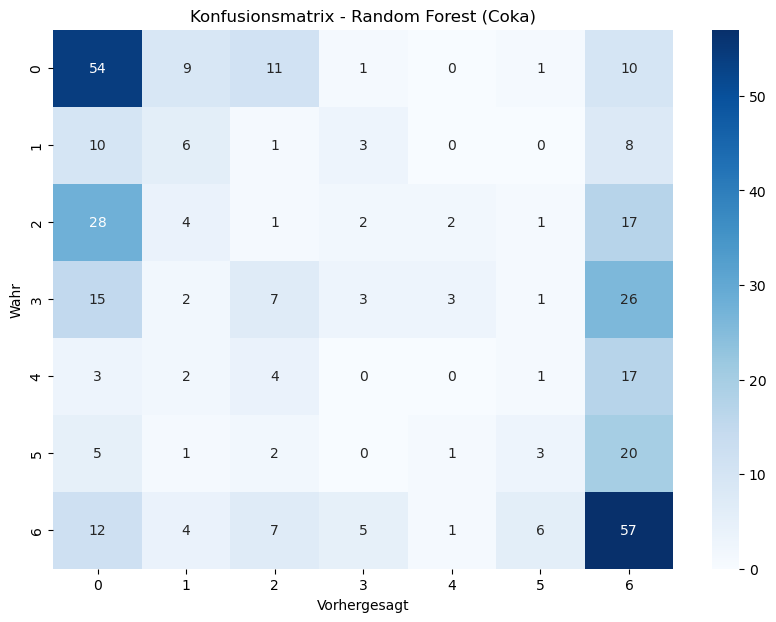

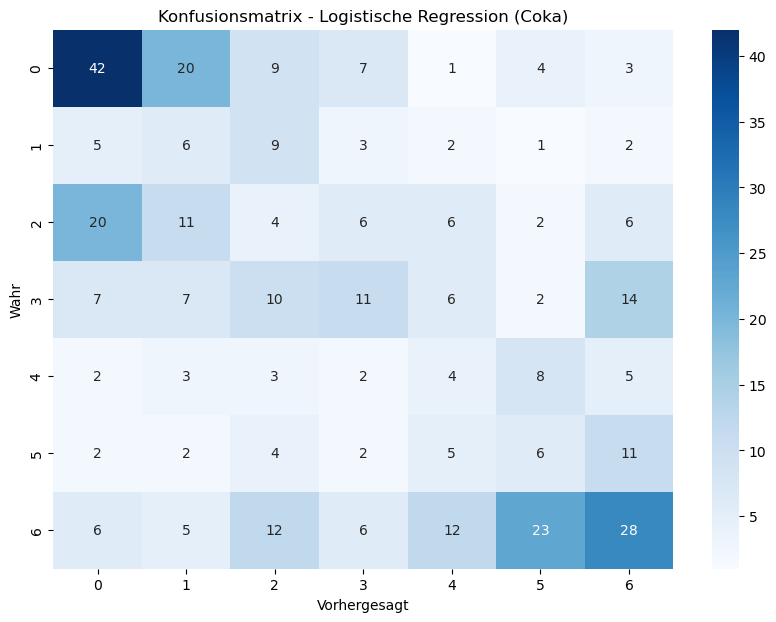

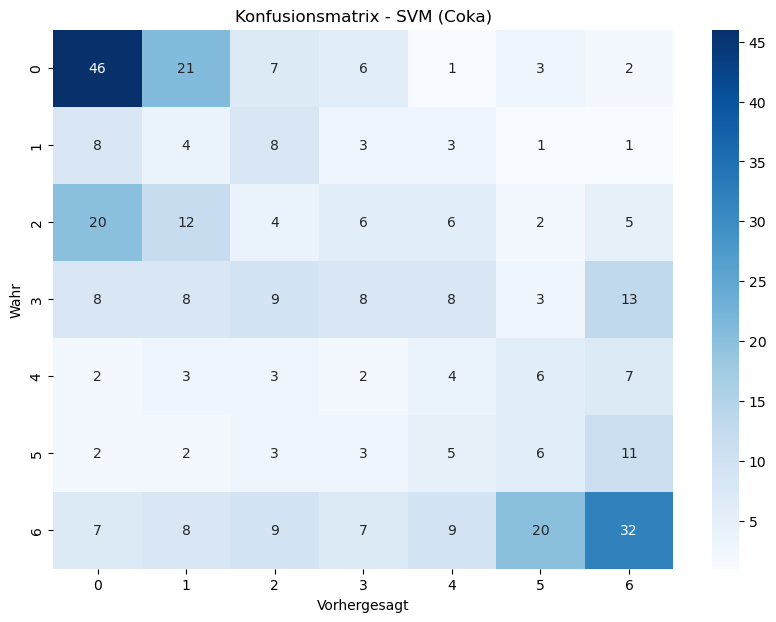

In [311]:
drug_names = ["Cannabis", "Nicotine", "Coka"]
models = ["Random Forest", "Logistische Regression", "SVM"]
predictions = [y_pred_rf, y_pred_logreg, y_pred_svm] 

for drug in drug_names:  
    for i in range(len(models)):  
        conf_matrix = confusion_matrix(y_test, predictions[i])

        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

        plt.title(f"Konfusionsmatrix - {models[i]} ({drug})")
        plt.xlabel("Vorhergesagt")
        plt.ylabel("Wahr")
        plt.show()

### Überprüfung der Klassen in den Vorhersagen

In [312]:
unique_classes = np.unique(y_test)
print("\nVorhergesagte Klassen:", np.unique(y_pred_rf))
print("Echte Klassen:", unique_classes)


Vorhergesagte Klassen: ['CL0' 'CL1' 'CL2' 'CL3' 'CL4' 'CL5' 'CL6']
Echte Klassen: ['CL0' 'CL1' 'CL2' 'CL3' 'CL4' 'CL5' 'CL6']


## Data Preparation

### Überprüfen auf Duplikate

In [313]:
print("Anzahl Duplikate im Datensatz: ", sum(X.duplicated()))

if sum(X.duplicated()) == 0: 
    print("Keine Duplikate im Datensatz.")

Anzahl Duplikate im Datensatz:  0
Keine Duplikate im Datensatz.


### Übersicht zu fehlenden Werten

In [314]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   education  1885 non-null   float64
 1   nscore     1885 non-null   float64
 2   escore     1885 non-null   float64
 3   oscore     1885 non-null   float64
 4   ascore     1885 non-null   float64
 5   cscore     1885 non-null   float64
 6   impuslive  1885 non-null   float64
 7   ss         1885 non-null   float64
dtypes: float64(8)
memory usage: 117.9 KB
None


Keine fehlenden oder doppelten Werte im Datensatz vorhanden. Somit müssen keine Einträge gelöscht / entfernt werden.